# CS 520 Project 2
Tejaswi Tripathi tt507
\
Contributions:

*   Designed upgraded bot
*   Calculated knowledge base updates

\
Ridwanur Sarder rrs148
\
Contributions:

*   Built environment
*   Built baseline bot

\
Collaborated on all else.
\
**Note: writeup & analysis at the bottom!!!!!**

Board Creation

In [ ]:
import random

# random.seed(42)

d = 30
#alpha = 0.2 #constant for rat radar sensitivity


#Helper method to check neighbors in board initialization
def checkNeighbors(grid, r, c, a):
  return [grid[r-1][c],grid[r+1][c],grid[r][c-1],grid[r][c+1]].count(a)

#Create new board with given edge length
def createBoard(d):
  grid = [[0 for _ in range(d+2)] for _ in range(d+2)]

  for j in range(d+2):
    grid[0][j] = 2
    grid[d+1][j] = 2
  for i in range(d+2):
    grid[i][0] = 2
    grid[i][d+1] = 2
  x = random.randint(1, d)
  y = random.randint(1, d)

  fringe = []
  fringe.append((x,y))

  deadEnds = []

  while len(fringe) > 0:
    curr = random.choice(fringe)
    fringe.remove(curr)
    r, c = curr[0], curr[1]
    if checkNeighbors(grid, r, c, 1) > 1:
      continue
    grid[r][c] = 1
    up = (r-1, c)
    down = (r+1, c)
    left = (r, c-1)
    right = (r, c+1)
    deadEnd = True
    for elt in [up, down, left, right]:
      if grid[elt[0]][elt[1]] == 0:
        numOpenNeighbors = checkNeighbors(grid, elt[0], elt[1], 1)
        if numOpenNeighbors == 1:
          deadEnd = False
          fringe.append(elt)
    if deadEnd:
      deadEnds.append(curr)

  for elt in deadEnds:
    if grid[elt[0]][elt[1]] == 2:
      deadEnds.remove(elt)
      continue
    numOpenNeighbors = checkNeighbors(grid, elt[0], elt[1], 1)
    if numOpenNeighbors > 1:
      deadEnds.remove(elt)

  newList = random.sample(deadEnds, len(deadEnds) // 2)
  for elt in newList:
    r = elt[0]
    c = elt[1]
    up = (r-1, c)
    down = (r+1, c)
    left = (r, c-1)
    right = (r, c+1)
    neighbors = [up,down,left,right]
    neighbors = [elt for elt in neighbors if grid[elt[0]][elt[1]] == 0]
    if neighbors == []:
      continue
    curr = random.choice(neighbors)
    grid[curr[0]][curr[1]] = 1

  for j in range(d+2):
    grid[0][j] = 0
    grid[d+1][j] = 0
  for i in range(d+2):
    grid[i][0] = 0
    grid[i][d+1] = 0
  return grid

# Rat init
def rat_init(grid):
  ratLoc = (random.randint(1, d), random.randint(1, d))
  while grid[ratLoc[0]][ratLoc[1]] == 0:
    ratLoc = (random.randint(1, d), random.randint(1, d))
  return ratLoc

# Bot init
def bot_init(grid):
  botLoc = (random.randint(1, d), random.randint(1, d))
  while grid[botLoc[0]][botLoc[1]] == 0:
    botLoc = (random.randint(1, d), random.randint(1, d))
  return botLoc

def location_init(grid):
  botLoc = bot_init(grid)
  ratLoc = rat_init(grid)
  while(ratLoc == botLoc):
    ratLoc = rat_init(grid)
  return botLoc, ratLoc

def grid_set_locs(grid, botLoc, ratLoc):
  grid[botLoc[0]][botLoc[1]] = 3
  grid[ratLoc[0]][ratLoc[1]] = 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

color_map_3 = {
    0: 'black', #blocked
    1: 'white', #open
    2: 'red', #rat
    3: 'green', #agent
}

color_map_4 = {
    0: 'black', #blocked
    1: 'white', #open
    2: 'red', #rat
    3: 'green', #agent
    4: 'blue', #path
}

def visualizeGrid(color_map, grid):
    fig, ax = plt.subplots()

    for i in range(len(grid)):
        for j in range(len(grid[i])):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=color_map[grid[i][j]]))

    ax.set_xlim(0, len(grid[0]))
    ax.set_ylim(0, len(grid))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    plt.gca().invert_yaxis()
    plt.show()

def probabiliyHeatmap(prb_grid):
  plt.imshow(prb_grid, cmap='viridis', interpolation='nearest')
  plt.colorbar()  # Add a colorbar to show probability values
  plt.title('Heatmap of Probabilities')
  plt.show()

In [ ]:
grid = createBoard(d)
botLoc, ratLoc = location_init(grid)
# grid_set_locs(grid, botLoc, ratLoc)
# visualizeGrid(color_map_3, grid)

Bot Actions Available

In [ ]:
import math

# sense surroundings for how many are currently blocked
def check_surroundings(grid, botCurrLoc):
  return [
      grid[botCurrLoc[0] + 1][botCurrLoc[1] + 1],
      grid[botCurrLoc[0]][botCurrLoc[1] + 1],
      grid[botCurrLoc[0] + 1][botCurrLoc[1]],
      grid[botCurrLoc[0] + 1][botCurrLoc[1] - 1],
      grid[botCurrLoc[0] - 1][botCurrLoc[1] + 1],
      grid[botCurrLoc[0] - 1][botCurrLoc[1]],
      grid[botCurrLoc[0]][botCurrLoc[1] - 1],
      grid[botCurrLoc[0] - 1][botCurrLoc[1]  - 1],
      ].count(0)

#manhattan helper method
def manhattan_distance(loc1, loc2):
    return abs(loc1[0] - loc2[0]) + abs(loc1[1] - loc2[1])

# space rat detector, returns distance on success, returns -1 otherwise
def check_rat(grid, botCurrLoc, ratLoc, alpha):
  distance = manhattan_distance(botCurrLoc, ratLoc)
  probability = math.exp(-alpha * (distance - 1))
  rand = random.random()
  # print((rand, probability))
  if rand < probability:
    return True
  return False

direction_map = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}

# move, returns location after moving and adjusts grid accordingly on success
def move_Bot(grid, botCurrLoc, dir):
  move_x, move_y = direction_map[dir]
  destination_row, destination_col = botCurrLoc[0] + move_x, botCurrLoc[1] + move_y
  # print(f"{botCurrLoc} moving {move_x,move_y} to {destination_row,destination_col}")
  if grid[destination_row][destination_col] != 0:
    grid[botCurrLoc[0]][botCurrLoc[1]] = 4
    grid[destination_row][destination_col] = 3
    return (destination_row, destination_col), True
  else:
    # print(f"Can't move {dir} to {destination_row, destination_col}")
    return botCurrLoc, False

# shortest path method
def shortest_path(grid, botLoc, dest, avoidVisited=False):
  fringe = []
  fringe.append(botLoc)

  closed_set = {}
  prev = {}
  prev[botLoc] = None

  while len(fringe) > 0:
      curr1 = fringe.pop(0)
      if curr1 == dest:
          break

      if curr1 not in closed_set:
          closed_set.update({curr1: 1})
          r1, c1 = curr1[0], curr1[1]
          neighbors1 = [(r1-1, c1),(r1+1, c1),(r1, c1-1),(r1, c1+1)]
          for elt in neighbors1:
              if grid[elt[0]][elt[1]] != 0 and elt not in closed_set:
                  # if avoidVisited:
                  #   continue
                  fringe.append(elt)
                  prev[elt] = curr1

  path = []
  curr = dest
  try:
      path.append(curr)
      curr = prev[curr]
  except:
      return False
  while curr is not None:
      path.append(curr)
      curr = prev[curr]
  return path[::-1]


In [ ]:
# print(check_rat(grid, botLoc,ratLoc, alpha))
# visualizeGrid(color_map_4, grid)

baseline bot loop

In [ ]:
import copy
from collections import OrderedDict, deque

def baseline_bot_loop(grid, botLoc, ratLoc, alpha):
  baseline_grid = copy.deepcopy(grid)
  grid_set_locs(baseline_grid, botLoc, ratLoc)
  number_steps = 0
  number_senses = 0
  number_pings = 0
  number_steps_away_from_rat = 0

  botCurrLoc = botLoc

  knowledgeBase = set()

  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] == 1:
        knowledgeBase.add((r, c))

  phase1Done = False # Set to true when we know where bot is
  alternatingMarker = False
  t = 0

  pathSoFar = []
  visited = set()
  visited.add(botCurrLoc)

  lastStep = None

  # visualizeGrid(color_map_4, baseline_grid)
  knowledgeBaseCycleDetector = deque()

  #phase 1 - identify where bot is
  while not phase1Done:
    if t > 500:
      raise Exception("Infinite!")
      return
    t += 1
    # print(f"{t},{len(knowledgeBase)}")

    alternatingMarker = not alternatingMarker

    currentKnowledgeBase = frozenset(knowledgeBase)

    # alternate between checking surroundings and moving
    if alternatingMarker: #sensing
      #check surroundings and adjust KB accordingly
      botSurroundingWalls = check_surroundings(grid, botCurrLoc)
      number_senses += 1
      possibleLocations = set()
      for cell in knowledgeBase:
        r, c = cell
        cellSurroundingWalls = check_surroundings(grid, cell)
        if botSurroundingWalls == cellSurroundingWalls and grid[r][c] != 0:
          possibleLocations.add((r,c))
      # if len(knowledgeBase) == len(possibleLocations):
      #   print(knowledgeBase)
      #   print(possibleLocations)
      #   print(opposite)
      #   # raise Exception("Infinite Loop Found!")
      knowledgeBase = possibleLocations
      if len(knowledgeBase) == 1: # we have found where we are
        # botCurrLoc = knowledgeBase.pop()
        phase1Done = True
        # print(f"Bot location at {botCurrLoc}, found in {t} steps.")
        # visualizeGrid(color_map_4, baseline_grid)
        break
    else: #move bot
      directionFreq = {'up': 0, 'down': 0, 'left': 0, 'right': 0}

      for loc in knowledgeBase:
        r, c = loc
        for direction, (dr, dc) in direction_map.items():
          newr, newc = r + dr, c + dc
          if grid[newr][newc] != 0:
            directionFreq[direction] += 1
      # print(directionFreq)
      maxDir = max(directionFreq, key=directionFreq.get)

      opposites_map = {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'}
      opposite = opposites_map.get(lastStep, None)

      if opposite != None:
        directionFreqFiltered = {k: v for k, v in directionFreq.items() if k != opposite}
        # print(directionFreqFiltered)
        if any(directionFreqFiltered.values()):
          maxDir = max(directionFreqFiltered, key=directionFreqFiltered.get)
        else:
          maxDir = max(directionFreq, key=directionFreq.get) #can move back if other directions have no count

      #select second highest frequency direction to break the cycle
      if currentKnowledgeBase in knowledgeBaseCycleDetector:
        raise Exception("cycle in grid phase 1")
        print("cycle in kb")
        directionFreq = {'up': 0, 'down': 0, 'left': 0, 'right': 0}
        for loc in knowledgeBase:
            r, c = loc
            for direction, (dr, dc) in direction_map.items():
                newr, newc = r + dr, c + dc
                if grid[newr][newc] != 0:
                    directionFreq[direction] += 1
        directionFreqCopy = copy.deepcopy(directionFreq)
        for direction, freq in directionFreqCopy.items():
          if freq == 0:
            directionFreq.pop(direction)
        sorted_dirs = sorted(directionFreq.items(), key=lambda item: item[1], reverse=True)
        maxDir = random.choice(sorted_dirs)[0]
        # print(sorted_dirs)

      else:
        knowledgeBaseCycleDetector.append(currentKnowledgeBase)

      lastStep = maxDir
      newLocation, moveStatus = move_Bot(baseline_grid, botCurrLoc, maxDir)
      number_steps += 1

      if moveStatus: #successful move
        # print("move success")
        botCurrLoc = newLocation

        pathSoFar.append(maxDir)
        visited.add(newLocation)

        newKnowledgeBase = set() # replace kb with entries that were okay to move in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if grid[newr][newc] != 0:
            newKnowledgeBase.add((newr, newc))
        # if len(knowledgeBase) == len(newKnowledgeBase):
        #   print(knowledgeBase)
        #   print(newKnowledgeBase)
        #   # print(t)
        #   # raise Exception("Infinite Loop Found in move bot! (successful move)")
        knowledgeBase = newKnowledgeBase
      else: #unsuccessful move
        # print("move fail")
        newKnowledgeBase = set() # replace kb with entries that were blocked in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if grid[newr][newc] == 0:
            newKnowledgeBase.add((r, c))
        # if len(knowledgeBase) == len(newKnowledgeBase):
        #   print(knowledgeBase)
        #   print(newKnowledgeBase)
        #   # print(t)
        #   # raise Exception("Infinite Loop Found in move bot! (unsuccessful move)")
        knowledgeBase = newKnowledgeBase
        if opposite is None:
          directionFreqFiltered = {k: v for k, v in directionFreq.items() if k != opposite}
          maxDir = max(directionFreqFiltered, key=directionFreqFiltered.get)
          opposite = opposites_map.get(maxDir, None)


      if len(knowledgeBase) == 1:
        # botCurrLoc = knowledgeBase.pop()
        visited.add(botCurrLoc)
        phase1Done = True
        # print(f"Bot location at {botCurrLoc}, found in {t} steps.")
        # visualizeGrid(color_map_4, baseline_grid)
        break
  # print(botCurrLoc)

  # visualizeGrid(color_map_3, grid)

  # reset
  alternatingMarker = False
  knowledgeBase = copy.deepcopy(grid) #set p_0 for each cell to just be 1/# open cells
  numberPossibleCells = sum(row.count(1) for row in knowledgeBase)
  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] != 0:
        knowledgeBase[r][c] = 1/numberPossibleCells
  totalPrb = 1

  # phase 2
  while(True):
    t += 1
    # print(t)
    alternatingMarker = not alternatingMarker
    if alternatingMarker == True: #ping for rat and update probabilities
      ping_response = check_rat(baseline_grid, botCurrLoc, ratLoc, alpha)
      number_pings += 1
      if ping_response:
        # print(f"ping at time {t}")
        if botCurrLoc == ratLoc: #if we are on the rat then return
          # visualizeGrid(color_map_4, baseline_grid)
          # probabiliyHeatmap(knowledgeBase)
          return number_steps, number_pings, number_senses, t, number_steps_away_from_rat

      for r in range(1, len(grid) - 1):
        for c in range(1, len(grid[r]) - 1):
          manhattan_distance_from_bot = manhattan_distance((r,c), botCurrLoc)
          if(ping_response):
            knowledgeBase[r][c] *= math.exp(-alpha*(manhattan_distance_from_bot-1))
          else:
            if manhattan_distance_from_bot == 0:
              knowledgeBase[r][c] = 0
              numberPossibleCells -= 1
            else:
              knowledgeBase[r][c] *= (1-math.exp(-alpha*(manhattan_distance_from_bot)))

      totalPrb = sum(sum(row) for row in knowledgeBase)
      knowledgeBase = [[x/totalPrb for x in row] for row in knowledgeBase]

      totalPrb = sum(sum(row) for row in knowledgeBase) # at this point it should be 1
      # if t % 10 == 0:
        # probabiliyHeatmap(knowledgeBase)
      # print(f"total prob: {totalPrb}")
      # probabiliyHeatmap(knowledgeBase)
    else:
      prb_list = []
      for i in range(len(knowledgeBase)):
        for j in range(len(knowledgeBase[i])):
          if((i,j) not in visited):
            prb_list.append((knowledgeBase[i][j],(i,j)))
      prb_list.sort(key=lambda x: x[0], reverse=True)
      max_cell_ind = prb_list[0][1]
      max_cell_value = prb_list[0][0]

      # print(f"max ind: val   {max_cell_ind}: {max_cell_value}")
      shortest_path_to_guess = shortest_path(grid, botCurrLoc, max_cell_ind)
      if not shortest_path_to_guess:
        print(prb_list)
        probabiliyHeatmap(knowledgeBase)
        visualizeGrid(color_map_4, baseline_grid)
        visualizeGrid(color_map_4, grid)
      # print(f"shortest path: {shortest_path_to_guess}")

      next_step = shortest_path_to_guess[1]
      direction = (next_step[0] - botCurrLoc[0], next_step[1] - botCurrLoc[1])
      direction = list(direction_map.keys())[list(direction_map.values()).index(direction)]
      new_loc = (botCurrLoc[0] + direction_map.get(direction)[0], botCurrLoc[1] + direction_map.get(direction)[1])
      if manhattan_distance(botCurrLoc, ratLoc) < manhattan_distance(new_loc , ratLoc):
        number_steps_away_from_rat += 1
      botCurrLoc, moveStatus = move_Bot(baseline_grid, botCurrLoc, direction)

      number_steps += 1
      pathSoFar.append(direction)
      visited.add(botCurrLoc)

botLoc, ratLoc = location_init(grid)
print(baseline_bot_loop(grid, botLoc, ratLoc, 0.2))

(49, 47, 3, 99, 2)


In [ ]:
# Probability grids

def update_probabilities(grid, probability_grid, botCurrLoc, alpha, ping):
  for r in range(1, len(probability_grid) - 1):
    for c in range(1, len(probability_grid[r]) - 1):
      manhattan_distance_from_bot = manhattan_distance((r,c), botCurrLoc)
      if manhattan_distance_from_bot == 0:
          probability_grid[r][c] = 0
      if(ping):
        probability_grid[r][c] *= math.exp(-alpha*(manhattan_distance_from_bot-1))
      else:
        probability_grid[r][c] *= (1-math.exp(-alpha*(manhattan_distance_from_bot)))

  totalPrb = sum(sum(row) for row in probability_grid)
  probability_grid = [[x/totalPrb for x in row] for row in probability_grid]
  # for row in knowledgeBase:
  #   print(row)
  totalPrb = sum(sum(row) for row in probability_grid) # at this point it should be 1
  return probability_grid

  # if ping:
  #   print("Ping!")
  # else:
  #   print("no ping :(")

  # data = sum(sum(row) for row in probability_grid)
  # probability_grid = [[x/data for x in row] for row in probability_grid]

  # for i in range(len(probability_grid)):
  #   for j in range(len(probability_grid[i])):
  #     if grid[i][j] == 0:
  #       probability_grid[i][j] = 0
  #       continue
  #     if (i,j) == botLoc:
  #       continue
  #     d = manhattan_distance((i,j), botLoc)
  #     likelihood = float(math.exp(-alpha*(d-1)))
  #     if not ping:
  #       likelihood = 1 - likelihood
  #     probability_grid[i][j] *= likelihood
  # return probability_grid

In [ ]:
# Ping code
def ping(alpha, botLoc, ratLoc):
  distance = manhattan_distance(botLoc, ratLoc)
  probability = math.exp(-alpha * (distance - 1))
  if random.random() < probability:
    return 1
  return 0

In [ ]:
# Utitilty function
def utility(theta_0, theta_1, p, d):
  return theta_0*p - theta_1*d

In [ ]:
# Phase 2 code
def phase_2(grid, botLoc, ratLoc, alpha, pathSoFar, visited, probability_grid):
  num_moves = 0
  num_pings = 0
  t = 0
  success = False
  distanceFromRat = manhattan_distance(botLoc, ratLoc)
  count_further = 0
  len_path = 15
  # alternateMarker = True
  count = 0

  while botLoc != ratLoc:
    # ping = ping(alpha, botLoc, ratLoc)

    num_ping_attempts = math.ceil(10 * math.exp(-13 * np.max(probability_grid)))
    for i in range(num_ping_attempts):
        probability_grid = update_probabilities(grid, probability_grid, botLoc, alpha, ping(alpha, botLoc, ratLoc))
        num_pings += 1
        t += 1
        # if movingRat:
        #   # OMG EWWWW THE RAT IS MOVING EWWWWWW
        #   grid[ratLoc[0]][ratLoc[1]] = 2
        #   ratLoc_dict = {'left': grid[ratLoc[0]][ratLoc[1] - 1],
        #             'right': grid[ratLoc[0]][ratLoc[1] + 1],
        #             'up': grid[ratLoc[0] - 1][ratLoc[1]],
        #             'down': grid[ratLoc[0] + 1][ratLoc[1]]
        #   }
        #   ratLoc_dict = {key: value for key, value in ratLoc_dict.items() if value != 0}
        #   dir = random.choice(list(ratLoc_dict.keys()))
        #   move_x, move_y = direction_map[dir]
        #   destination_row, destination_col = ratLoc[0] + move_x, ratLoc[1] + move_y
        #   ratLoc = (destination_row, destination_col)
        #   grid[ratLoc[0]][ratLoc[1]] = 2
        # probabiliyHeatmap(probability_grid)
    # print(sum(sum(row) for row in probability_grid))
    utilities = {}
    # theta_1 = np.max(probability_grid)
    for i in range(len(probability_grid)):
      for j in range(len(probability_grid[i])):
        if grid[i][j] == 0:
          utilities[(i,j)] = -100000
          continue
        d = manhattan_distance((i,j), botLoc)
        utilities[(i,j)] = utility(1, 10**(-8), probability_grid[i][j], d)
    # print(max(utilities))
    # dest = max({k: v for k, v in utilities.values() if k not in visited})           # accounting for visited cells
    dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
    path = shortest_path(grid, botLoc, dest)
    while not path:
      utilities.pop(dest)
      dest = max((k for k in utilities if k not in visited), key=utilities.get, default=None)
      # dest = max({k: v for k, v in utilities.items() if k not in visited})
      path = shortest_path(grid, botLoc, dest)


    # print(visited)
    len_path = len(path)

    if len_path > 25:
      path = path[:max(2, len_path // 2)]
    num_moves += len(path)
    t += len(path)
    dest = path[-1]
    # if movingRat:
    #   for i in range(len(path)):
    #     # OMG EWWWW THE RAT IS MOVING EWWWWWW
    #     grid[ratLoc[0]][ratLoc[1]] = 2
    #     ratLoc_dict = {'left': grid[ratLoc[0]][ratLoc[1] - 1],
    #               'right': grid[ratLoc[0]][ratLoc[1] + 1],
    #               'up': grid[ratLoc[0] - 1][ratLoc[1]],
    #               'down': grid[ratLoc[0] + 1][ratLoc[1]]
    #     }
    #     ratLoc_dict = {key: value for key, value in ratLoc_dict.items() if value != 0}
    #     dir = random.choice(list(ratLoc_dict.keys()))
    #     move_x, move_y = direction_map[dir]
    #     destination_row, destination_col = ratLoc[0] + move_x, ratLoc[1] + move_y
    #     ratLoc = (destination_row, destination_col)
    #     grid[ratLoc[0]][ratLoc[1]] = 2

    visited.add(dest)                      # adding destination to visited
    botLoc = dest
    pathSoFar += path
    newDistanceFromRat = manhattan_distance(botLoc, ratLoc)
    if newDistanceFromRat > distanceFromRat:
      # print("Bot is further away from rat!")
      count_further += 1
    # distanceFromRat = newDistanceFromRat
    # if count > 25:
    #   print("Sanity check failed.")
    #   return success, pathSoFar, num_pings, num_moves, t
    for i in path:
      grid[i[0]][i[1]] = 4

    grid[botLoc[0]][botLoc[1]] = 3
    grid[ratLoc[0]][ratLoc[1]] = 2
    # visualizeGrid(color_map_4, grid)
    if count >= num_ping_attempts:
      alternateMarker = True
      count = 0


  success = True
  return success, pathSoFar, num_pings, num_moves, t, count_further

In [ ]:
import pandas as pd

def upgraded_bot_loop(grid, botLoc, ratLoc, alpha):
  prob_grid_2 = copy.deepcopy(grid)
  numberPossibleCells = sum(row.count(1) for row in prob_grid_2)
  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] != 0:
        prob_grid_2[r][c] = 1/numberPossibleCells
  bot2_grid = copy.deepcopy(grid)
  grid_set_locs(bot2_grid, botLoc, ratLoc)

  pings = []
  pos_x = []
  pos_y = []

  # df_p = pd.DataFrame(data = {'ping': [], 'pos_x': [], 'pos_y': []})

  botCurrLoc = botLoc
  botRelativeLoc = (0,0)

  knowledgeBase = set()

  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] == 1:
        knowledgeBase.add((r, c))
  # print(knowledgeBase)

  # visualizeGrid(color_map_4, bot2_grid)

  phase1Done = False # Set to true when we know where bot is
  alternatingMarker = False
  t = 0

  pathSoFar = []
  visited = set()
  visited.add(botCurrLoc)

  lastStep = None

  num_moves = 0
  num_senses = 0
  num_pings = 0
  count_further = 0

  #phase 1 - identify where bot is
  while not phase1Done:
    if botCurrLoc == ratLoc:
      return num_moves, num_senses, num_pings, t, count_further
      break

    t += 1
    # print(knowledgeBase)

    alternatingMarker = not alternatingMarker

    # alternate between checking surroundings and moving
    if alternatingMarker: #sensing
      num_senses += 1
      # print(f"sensing {botCurrLoc}")
      #check surroundings and adjust KB accordingly
      botSurroundingWalls = check_surroundings(bot2_grid, botCurrLoc)
      possibleLocations = set()
      for cell in knowledgeBase:
        r, c = cell
        # print(f"sensingg {cell}")
        cellSurroundingWalls = check_surroundings(bot2_grid, cell)
        if botSurroundingWalls == cellSurroundingWalls and bot2_grid[r][c] != 0:
          possibleLocations.add((r,c))
      knowledgeBase = possibleLocations
      if len(knowledgeBase) == 1: # we have found where we are
        # botCurrLoc = knowledgeBase.pop()
        phase1Done = True
        # visualizeGrid(color_map_4, bot2_grid)
        break
    else: #move bot
      num_moves += 1
      directionFreq = {'up': 0, 'down': 0, 'left': 0, 'right': 0}

      for loc in knowledgeBase:
        r, c = loc
        for direction, (dr, dc) in direction_map.items():
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] != 0:
            directionFreq[direction] += 1
      # print(directionFreq)
      maxDir = max(directionFreq, key=directionFreq.get)

      opposites_map = {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'}
      opposite = opposites_map.get(lastStep, None)

      if opposite != None:
        directionFreqFiltered = {k: v for k, v in directionFreq.items() if k != opposite}
        # print(directionFreqFiltered)
        if any(directionFreqFiltered.values()):
          maxDir = max(directionFreqFiltered, key=directionFreqFiltered.get)
        else:
          maxDir = max(directionFreq, key=directionFreq.get) #can move back if other directions have no count

# direction_map = {
#     'up': (-1, 0),
#     'down': (1, 0),
#     'left': (0, -1),
#     'right': (0, 1)
# }

      pings.append(ping(alpha, botCurrLoc, ratLoc))                             # Ping!
      pos_x.append(botRelativeLoc[0] + direction_map[maxDir][0])
      pos_y.append(botRelativeLoc[1] + direction_map[maxDir][1])


      # new_row = pd.DataFrame({'ping': ping(alpha, botCurrLoc, ratLoc),
      #              'pos_x': botRelativeLoc[0] + direction_map[maxDir][0],
      #              'pos_y': botRelativeLoc[1] + direction_map[maxDir][1]
      #              })
      # df_p = pd.concat([df_p, new_row])
      num_pings += 1

      lastStep = maxDir

      newLocation, moveStatus = move_Bot(bot2_grid, botCurrLoc, maxDir)

      if moveStatus: #successful move
        botCurrLoc = newLocation

        pathSoFar.append(maxDir)
        visited.add(newLocation)

        newKnowledgeBase = set() # replace kb with entries that were okay to move in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] != 0:
            newKnowledgeBase.add((newr, newc))
        knowledgeBase = newKnowledgeBase
      else: #unsuccessful move
        newKnowledgeBase = set() # replace kb with entries that were blocked in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] == 0:
            newKnowledgeBase.add((r, c))
        knowledgeBase = newKnowledgeBase

      if len(knowledgeBase) == 1:
        # botCurrLoc = knowledgeBase.pop()
        visited.add(botCurrLoc)
        phase1Done = True
        # visualizeGrid(color_map_4, bot2_grid)
        break


  # Phase 2
  for i in range(len(pings) - 1, -1, -1):
    # j = botCurrLoc - (pos_x[i], pos_y[i])
    j = tuple(x - y for x, y in zip(botCurrLoc, (pos_x[i], pos_y[i])))
    prob_grid_2 = update_probabilities(bot2_grid, prob_grid_2, j, alpha, pings[i])

  pathSoFar_2 = []
  num_pings_2, num_moves_2, t_2= 0,0,0

  success, pathSoFar_2, num_pings_2, num_moves_2, t_2, count_further = phase_2(bot2_grid, botCurrLoc, ratLoc, alpha, pathSoFar_2, visited, prob_grid_2)

  num_moves += num_moves_2
  num_pings += num_pings_2
  t += t_2

  # if success:
  #   print(f"Process completed in {t} timesteps, {num_moves} moves, and {num_pings} pings.")

  # print(pathSoFar_2)
  for i in pathSoFar_2:
    bot2_grid[i[0]][i[1]] = 4
  # if success:
  bot2_grid[botLoc[0]][botLoc[1]] = 3
  bot2_grid[ratLoc[0]][ratLoc[1]] = 2
  # visualizeGrid(color_map_4, bot2_grid)
  return num_moves, num_pings, num_senses, t, count_further



In [ ]:
num_moves, num_pings, num_senses, t, count_further = upgraded_bot_loop(grid, botLoc, ratLoc, 0.04)
print(num_moves, num_pings, num_senses, t, count_further)

133 83 3 216 0


# The Moving Rat Situation

In [ ]:
# Baseline bot with moving rat
def update_probabilities_baseline(grid, knowledgeBase, alpha, botCurrLoc, ping):
  directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
  newKnowledgeBase = copy.deepcopy(knowledgeBase)
  for i in range(len(grid[1:])):
    for j in range(len(grid[i])):
      if grid[i][j] == 0:
        newKnowledgeBase[i][j] = 0
        continue
      # lenth = len(shortest_path(grid, (i,j), botLoc))
      neighbors = []
      # Loop over each direction and check the neighbor
      for dr, dc in directions:
          ni, nj = i + dr, j + dc  # Neighbor coordinates
          if 0 <= ni < len(newKnowledgeBase) and 0 <= nj < len(newKnowledgeBase[0]):  # Check bounds
              if newKnowledgeBase[ni][nj] != 0:  # Check if neighbor is non-zero
                  neighbors.append((ni, nj))
      p_transition = 0
      p_prior = 0
      sum = []
      for elt in neighbors:
        numOpen = sum(
            1 for dr, dc in directions
            if 0 <= elt[0] + dr < len(grid) and 0 <= elt[1] + dc < len(grid[0]) and grid[elt[0] + dr][elt[1] + dc] != 0
        )
        p_transition = 1 / numOpen
        p_prior = knowledgeBase[elt[0]][elt[1]]
        sum.append(p_transition*p_prior)
      newKnowledgeBase[i][j] = sum(sum)
    return newKnowledgeBase


  # def checkOpenNeighbors(r,c,grid):
  #   neighbor_up = grid[r-1][c]
  #   neighbor_down = grid[r+1][c]
  #   neighbor_left = grid[r][c-1]
  #   neighbor_right = grid[r][c+1]
  #   neighbors = [neighbor_up, neighbor_down, neighbor_left, neighbor_right]
  #   neighbor_coords = [(r-1, c), (r+1, c), (r, c-1), (r, c+1)]
  #   return [neighbor_coord for neighbor_coord in neighbor_coords if grid[neighbor_coord[0]][neighbor_coord[1]] != 0], neighbors.count(1)

  # def sumTransitionModel(r,c,knowledgeBase, grid):
  #   openNeighborCoords, numOpenNeighbors = checkOpenNeighbors(r,c,grid)
  #   if numOpenNeighbors == 0:
  #     return 0
  #   sum = 0
  #   for neighborCoord in openNeighborCoords:
  #     _, numNeighborsNeighbors = checkOpenNeighbors(neighborCoord[0], neighborCoord[1], grid)
  #     if numNeighborsNeighbors == 0:
  #       continue
  #     sum += knowledgeBase[neighborCoord[0]][neighborCoord[1]] * (1/numNeighborsNeighbors)
  #   return sum


  # numberPossibleCells = sum(row.count(1) for row in grid)

  # newKnowledgeBase = copy.deepcopy(knowledgeBase)
  # for r in range(1, len(knowledgeBase) - 1):
  #   for c in range(1, len(knowledgeBase[r]) - 1):
  #     if grid[r][c] == 0:
  #       continue
  #     belief = knowledgeBase[r][c]
  #     sumTransition = sumTransitionModel(r,c,knowledgeBase, grid)
  #     observationModel = math.exp(-alpha*(manhattan_distance((r,c), botCurrLoc)-1)) if ping else 1-math.exp(-alpha*(manhattan_distance((r,c), botCurrLoc) - 1))
  #     newKnowledgeBase[r][c] = belief * observationModel * sumTransition
  # totalPrb = sum(sum(row) for row in newKnowledgeBase)
  # newKnowledgeBase = [[x/totalPrb for x in row] for row in newKnowledgeBase]
  # return newKnowledgeBase


In [ ]:
def baseline_bot_loop_movingRat(grid, botLoc, ratLoc, alpha):
  baseline_grid = copy.deepcopy(grid)
  grid_set_locs(baseline_grid, botLoc, ratLoc)
  number_steps = 0
  number_senses = 0
  number_pings = 0
  number_steps_away_from_rat = 0

  botCurrLoc = botLoc

  knowledgeBase = set()

  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] == 1:
        knowledgeBase.add((r, c))

  phase1Done = False # Set to true when we know where bot is
  alternatingMarker = False
  t = 0

  pathSoFar = []
  visited = set()
  visited.add(botCurrLoc)

  lastStep = None

  # visualizeGrid(color_map_4, baseline_grid)
  knowledgeBaseCycleDetector = deque()

  #phase 1 - identify where bot is
  while not phase1Done:
    if t > 500:
      raise Exception("Infinite!")
      return
    t += 1
    # print(f"{t},{len(knowledgeBase)}")

    alternatingMarker = not alternatingMarker

    currentKnowledgeBase = frozenset(knowledgeBase)

    # alternate between checking surroundings and moving
    if alternatingMarker: #sensing
      #check surroundings and adjust KB accordingly
      botSurroundingWalls = check_surroundings(grid, botCurrLoc)
      number_senses += 1
      possibleLocations = set()
      for cell in knowledgeBase:
        r, c = cell
        cellSurroundingWalls = check_surroundings(grid, cell)
        if botSurroundingWalls == cellSurroundingWalls and grid[r][c] != 0:
          possibleLocations.add((r,c))
      # if len(knowledgeBase) == len(possibleLocations):
      #   print(knowledgeBase)
      #   print(possibleLocations)
      #   print(opposite)
      #   # raise Exception("Infinite Loop Found!")
      knowledgeBase = possibleLocations
      if len(knowledgeBase) == 1: # we have found where we are
        # botCurrLoc = knowledgeBase.pop()
        phase1Done = True
        # print(f"Bot location at {botCurrLoc}, found in {t} steps.")
        # visualizeGrid(color_map_4, baseline_grid)
        break
    else: #move bot
      directionFreq = {'up': 0, 'down': 0, 'left': 0, 'right': 0}

      for loc in knowledgeBase:
        r, c = loc
        for direction, (dr, dc) in direction_map.items():
          newr, newc = r + dr, c + dc
          if grid[newr][newc] != 0:
            directionFreq[direction] += 1
      # print(directionFreq)
      maxDir = max(directionFreq, key=directionFreq.get)

      opposites_map = {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'}
      opposite = opposites_map.get(lastStep, None)

      if opposite != None:
        directionFreqFiltered = {k: v for k, v in directionFreq.items() if k != opposite}
        # print(directionFreqFiltered)
        if any(directionFreqFiltered.values()):
          maxDir = max(directionFreqFiltered, key=directionFreqFiltered.get)
        else:
          maxDir = max(directionFreq, key=directionFreq.get) #can move back if other directions have no count

      #select second highest frequency direction to break the cycle
      if currentKnowledgeBase in knowledgeBaseCycleDetector:
        raise Exception("cycle in grid phase 1")
        print("cycle in kb")
        directionFreq = {'up': 0, 'down': 0, 'left': 0, 'right': 0}
        for loc in knowledgeBase:
            r, c = loc
            for direction, (dr, dc) in direction_map.items():
                newr, newc = r + dr, c + dc
                if grid[newr][newc] != 0:
                    directionFreq[direction] += 1
        directionFreqCopy = copy.deepcopy(directionFreq)
        for direction, freq in directionFreqCopy.items():
          if freq == 0:
            directionFreq.pop(direction)
        sorted_dirs = sorted(directionFreq.items(), key=lambda item: item[1], reverse=True)
        maxDir = random.choice(sorted_dirs)[0]
        # print(sorted_dirs)

      else:
        knowledgeBaseCycleDetector.append(currentKnowledgeBase)

      lastStep = maxDir
      newLocation, moveStatus = move_Bot(baseline_grid, botCurrLoc, maxDir)
      number_steps += 1

      if moveStatus: #successful move
        # print("move success")
        botCurrLoc = newLocation

        pathSoFar.append(maxDir)
        visited.add(newLocation)

        newKnowledgeBase = set() # replace kb with entries that were okay to move in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if grid[newr][newc] != 0:
            newKnowledgeBase.add((newr, newc))
        # if len(knowledgeBase) == len(newKnowledgeBase):
        #   print(knowledgeBase)
        #   print(newKnowledgeBase)
        #   # print(t)
        #   # raise Exception("Infinite Loop Found in move bot! (successful move)")
        knowledgeBase = newKnowledgeBase
      else: #unsuccessful move
        # print("move fail")
        newKnowledgeBase = set() # replace kb with entries that were blocked in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if grid[newr][newc] == 0:
            newKnowledgeBase.add((r, c))
        # if len(knowledgeBase) == len(newKnowledgeBase):
        #   print(knowledgeBase)
        #   print(newKnowledgeBase)
        #   # print(t)
        #   # raise Exception("Infinite Loop Found in move bot! (unsuccessful move)")
        knowledgeBase = newKnowledgeBase
        if opposite is None:
          directionFreqFiltered = {k: v for k, v in directionFreq.items() if k != opposite}
          maxDir = max(directionFreqFiltered, key=directionFreqFiltered.get)
          opposite = opposites_map.get(maxDir, None)


      if len(knowledgeBase) == 1:
        # botCurrLoc = knowledgeBase.pop()
        visited.add(botCurrLoc)
        phase1Done = True
        # print(f"Bot location at {botCurrLoc}, found in {t} steps.")
        # visualizeGrid(color_map_4, baseline_grid)
        break

    # OMG EWWWW THE RAT IS MOVING EWWWWWW
    ratLoc_dict = {'left': baseline_grid[ratLoc[0]][ratLoc[1] - 1],
              'right': baseline_grid[ratLoc[0]][ratLoc[1] + 1],
              'up': baseline_grid[ratLoc[0] - 1][ratLoc[1]],
              'down': baseline_grid[ratLoc[0] + 1][ratLoc[1]]
    }
    ratLoc_dict = {key: value for key, value in ratLoc_dict.items() if value != 0}
    dir = random.choice(list(ratLoc_dict.keys()))
    move_x, move_y = direction_map[dir]
    destination_row, destination_col = ratLoc[0] + move_x, ratLoc[1] + move_y
    ratLoc = (destination_row, destination_col)
    baseline_grid[ratLoc[0]][ratLoc[1]] = 2

  # print(botCurrLoc)

  # visualizeGrid(color_map_3, grid)

  # reset
  alternatingMarker = False
  knowledgeBase = copy.deepcopy(grid) #set p_0 for each cell to just be 1/# open cells
  numberPossibleCells = sum(row.count(1) for row in knowledgeBase)
  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] != 0:
        knowledgeBase[r][c] = 1/numberPossibleCells
  totalPrb = 1

  # phase 2
  while(True):
    # probabiliyHeatmap(knowledgeBase)
    t += 1
    # print(t)
    alternatingMarker = not alternatingMarker
    if alternatingMarker == True: #ping for rat and update probabilities
      ping_response = check_rat(baseline_grid, botCurrLoc, ratLoc, alpha)
      number_pings += 1
      if ping_response:
        # print(f"ping at time {t}")
        if botCurrLoc == ratLoc: #if we are on the rat then return
          # visualizeGrid(color_map_4, baseline_grid)
          # probabiliyHeatmap(knowledgeBase)
          return number_steps, number_pings, number_senses, t, number_steps_away_from_rat
      if botCurrLoc != ratLoc:
        knowledgeBase[r][c] = 0
      knowledgeBase = update_probabilities_baseline(grid, knowledgeBase, alpha, botCurrLoc, ping_response)
      knowledgeBase[r][c] = 1/numberPossibleCells
      totalPrb = sum(sum(row) for row in knowledgeBase) # at this point it should be 1
      # if t % 10 == 0:
        # probabiliyHeatmap(knowledgeBase)
      # print(f"total prob: {totalPrb}")
      # probabiliyHeatmap(knowledgeBase)
    else:
      prb_list = []
      for i in range(len(knowledgeBase)):
        for j in range(len(knowledgeBase[i])):
          if((i,j) not in visited):
            prb_list.append((knowledgeBase[i][j],(i,j)))
      prb_list.sort(key=lambda x: x[0], reverse=True)
      max_cell_ind = prb_list[0][1]
      max_cell_value = prb_list[0][0]

      # print(f"max ind: val   {max_cell_ind}: {max_cell_value}")
      shortest_path_to_guess = shortest_path(grid, botCurrLoc, max_cell_ind)
      if not shortest_path_to_guess:
        # print(prb_list)
        raise Exception()
        # probabiliyHeatmap(knowledgeBase)
        # visualizeGrid(color_map_4, baseline_grid)
        # visualizeGrid(color_map_4, grid)
      # print(f"shortest path: {shortest_path_to_guess}")

      next_step = shortest_path_to_guess[1]
      direction = (next_step[0] - botCurrLoc[0], next_step[1] - botCurrLoc[1])
      direction = list(direction_map.keys())[list(direction_map.values()).index(direction)]
      new_loc = (botCurrLoc[0] + direction_map.get(direction)[0], botCurrLoc[1] + direction_map.get(direction)[1])
      if manhattan_distance(botCurrLoc, ratLoc) < manhattan_distance(new_loc , ratLoc):
        number_steps_away_from_rat += 1
      botCurrLoc, moveStatus = move_Bot(baseline_grid, botCurrLoc, direction)

      number_steps += 1
      pathSoFar.append(direction)
      visited.add(botCurrLoc)

    # OMG EWWWW THE RAT IS MOVING EWWWWWW
    ratLoc_dict = {'left': baseline_grid[ratLoc[0]][ratLoc[1] - 1],
              'right': baseline_grid[ratLoc[0]][ratLoc[1] + 1],
              'up': baseline_grid[ratLoc[0] - 1][ratLoc[1]],
              'down': baseline_grid[ratLoc[0] + 1][ratLoc[1]]
    }
    ratLoc_dict = {key: value for key, value in ratLoc_dict.items() if value != 0}
    dir = random.choice(list(ratLoc_dict.keys()))
    move_x, move_y = direction_map[dir]
    destination_row, destination_col = ratLoc[0] + move_x, ratLoc[1] + move_y
    ratLoc = (destination_row, destination_col)
    baseline_grid[ratLoc[0]][ratLoc[1]] = 2

botLoc, ratLoc = location_init(grid)


print(baseline_bot_loop_movingRat(grid, botLoc, ratLoc, 0.12))

(1561, 1557, 6, 3124, 777)


In [ ]:
# Rat simulation for upgraded bot, moving rat

def simulate_rat(grid, botLoc, cell):
  dist = len(shortest_path(grid, botLoc, cell))
  cells = []
  for j in range(25):
    cell_j = copy.deepcopy(cell)
    for i in range(dist):
      # OMG EWWWW THE RAT IS MOVING EWWWWWW
      ratLoc_dict = {'left': grid[cell_j[0]][cell_j[1] - 1],
                'right': grid[cell_j[0]][cell_j[1] + 1],
                'up': grid[cell_j[0] - 1][cell_j[1]],
                'down': grid[cell_j[0] + 1][cell_j[1]]
      }
      ratLoc_dict = {key: value for key, value in ratLoc_dict.items() if value != 0}
      dir = random.choice(list(ratLoc_dict.keys()))
      move_x, move_y = direction_map[dir]
      destination_row, destination_col = cell_j[0] + move_x, cell_j[1] + move_y
      cell_j = (destination_row, destination_col)
    cells.append(cell_j)
  return max(set(cells), key=cells.count)

In [ ]:
# Phase 2 for upgraded bot, moving rat

def phase_2_movingRat(grid, botLoc, ratLoc, alpha, pathSoFar, probability_grid):
  directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
  num_moves = 0
  num_pings = 0
  t = 0
  success = False
  distanceFromRat = manhattan_distance(botLoc, ratLoc)
  count_further = 0
  len_path = 15
  # alternateMarker = True
  count = 0

  while botLoc != ratLoc:

    # dist_dict = {}
    # for i in range(len(grid)):
    #   for j in range(len(grid[i])):
    #     if grid[i][j] == 0:
    #       continue
    #     dist_dict[(i,j)] = len(shortest_path(grid, (i,j), botLoc))

    # ping = ping(alpha, botLoc, ratLoc)

    num_ping_attempts = math.ceil(10 * math.exp(-13 * np.max(probability_grid)))
    for i in range(num_ping_attempts):
      probability_grid = update_probabilities(grid, probability_grid, botLoc, alpha, ping(alpha, botLoc, ratLoc))
      num_pings += 1
      t += 1
      # OMG EWWWW THE RAT IS MOVING EWWWWWW
      grid[ratLoc[0]][ratLoc[1]] = 2
      ratLoc_dict = {'left': grid[ratLoc[0]][ratLoc[1] - 1],
                'right': grid[ratLoc[0]][ratLoc[1] + 1],
                'up': grid[ratLoc[0] - 1][ratLoc[1]],
                'down': grid[ratLoc[0] + 1][ratLoc[1]]
      }
      ratLoc_dict = {key: value for key, value in ratLoc_dict.items() if value != 0}
      dir = random.choice(list(ratLoc_dict.keys()))
      move_x, move_y = direction_map[dir]
      destination_row, destination_col = ratLoc[0] + move_x, ratLoc[1] + move_y
      ratLoc = (destination_row, destination_col)
      grid[ratLoc[0]][ratLoc[1]] = 2
      # probabiliyHeatmap(probability_grid)

    # prediction_grid[botLoc[0]][botLoc[1]] = probability_grid[botLoc[0]][botLoc[1]]
    # for cell, distance in dict(sorted(dist_dict.items(), key=lambda item: item[1])) if distance > 0:
    #   non_zero_neighbors = [
    #       (cell[0] + dr, cell[1] + dc)
    #       for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]
    #       if 0 <= cell[0] + dr < len(prediction_grid)
    #       and 0 <= cell[1] + dc < len(prediction_grid[0])
    #       and prediction_grid[cell[0] + dr][cell[1] + dc] != 0
    #       and dist_dict.get((cell[0] + dr, cell[1] + dc), float('inf')) < distance
    #   ]
    #   if non_zero_neighbors = []:
    #     continue
    #   sum = []
    #   for elt in non_zero_neighbors:
    #     numOpen = sum(
    #         1 for dr, dc in directions
    #         if 0 <= elt[0] + dr < len(grid) and 0 <= elt[1] + dc < len(grid[0]) and grid[elt[0] + dr][elt[1] + dc] != 0
    #     )
    #     p_transition = 1 / numOpen
    #     p_prior = prediction_grid[elt[0]][elt[1]]
    #     sum.append(p_transition*p_prior)
    #   prediction_grid[cell[0]][cell[1]] = sum(sum)


    utilities = {}
    # theta_1 = np.max(probability_grid)
    for i in range(len(probability_grid)):
      for j in range(len(probability_grid[i])):
        if grid[i][j] == 0:
          utilities[(i,j)] = -100000
          continue
        d = manhattan_distance((i,j), botLoc)
        utilities[(i,j)] = utility(1, 10**(-8), probability_grid[i][j], d)
    # print(max(utilities))
    # dest = max({k: v for k, v in utilities.values() if k not in visited})           # accounting for visited cells
    dest = max((k for k in utilities), key=utilities.get, default=None)
    dest = simulate_rat(grid, botLoc, dest)
    path = shortest_path(grid, botLoc, dest)
    while not path:
      utilities.pop(dest)
      dest = max((k for k in utilities), key=utilities.get, default=None)
      dest = simulate_rat(grid, botLoc, dest)
      # dest = max({k: v for k, v in utilities.items() if k not in visited})
      path = shortest_path(grid, botLoc, dest)


    # print(visited)
    len_path = len(path)

    if len_path > 25:
      path = path[:max(2, len_path // 2)]
    num_moves += len(path)
    t += len(path)
    dest = path[-1]
    for i in range(len(path)):
      # OMG EWWWW THE RAT IS MOVING EWWWWWW
      grid[ratLoc[0]][ratLoc[1]] = 2
      ratLoc_dict = {'left': grid[ratLoc[0]][ratLoc[1] - 1],
                'right': grid[ratLoc[0]][ratLoc[1] + 1],
                'up': grid[ratLoc[0] - 1][ratLoc[1]],
                'down': grid[ratLoc[0] + 1][ratLoc[1]]
      }
      ratLoc_dict = {key: value for key, value in ratLoc_dict.items() if value != 0}
      dir = random.choice(list(ratLoc_dict.keys()))
      move_x, move_y = direction_map[dir]
      destination_row, destination_col = ratLoc[0] + move_x, ratLoc[1] + move_y
      ratLoc = (destination_row, destination_col)
      grid[ratLoc[0]][ratLoc[1]] = 2

    # visited.add(dest)                      # adding destination to visited
    botLoc = dest
    pathSoFar += path
    newDistanceFromRat = manhattan_distance(botLoc, ratLoc)
    if newDistanceFromRat > distanceFromRat:
      # print("Bot is further away from rat!")
      count_further += 1
    # distanceFromRat = newDistanceFromRat
    # if count > 25:
    #   print("Sanity check failed.")
    #   return success, pathSoFar, num_pings, num_moves, t
    for i in path:
      grid[i[0]][i[1]] = 4

    grid[botLoc[0]][botLoc[1]] = 3
    grid[ratLoc[0]][ratLoc[1]] = 2
    # visualizeGrid(color_map_4, grid)
    if count >= num_ping_attempts:
      alternateMarker = True
      count = 0


  success = True
  return success, pathSoFar, num_pings, num_moves, t, count_further

In [ ]:
# Upgraded bot with moving rat

def upgraded_bot_movingRat(grid, botLoc, ratLoc, alpha):
  prob_grid_2 = copy.deepcopy(grid)
  numberPossibleCells = sum(row.count(1) for row in prob_grid_2)
  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] != 0:
        prob_grid_2[r][c] = 1/numberPossibleCells
  bot2_grid = copy.deepcopy(grid)
  grid_set_locs(bot2_grid, botLoc, ratLoc)

  pings = []
  pos_x = []
  pos_y = []

  # df_p = pd.DataFrame(data = {'ping': [], 'pos_x': [], 'pos_y': []})

  botCurrLoc = botLoc
  botRelativeLoc = (0,0)

  knowledgeBase = set()

  for r in range(1, len(grid) - 1):
    for c in range(1, len(grid[r]) - 1):
      if grid[r][c] == 1:
        knowledgeBase.add((r, c))
  # print(knowledgeBase)

  # visualizeGrid(color_map_4, bot2_grid)

  phase1Done = False # Set to true when we know where bot is
  alternatingMarker = False
  t = 0

  pathSoFar = []
  visited = set()
  visited.add(botCurrLoc)

  lastStep = None

  num_moves = 0
  num_senses = 0
  num_pings = 0
  count_further = 0

  #phase 1 - identify where bot is
  while not phase1Done:
    if botCurrLoc == ratLoc:
      return num_moves, num_senses, num_pings, t, count_further
      break

    t += 1
    # print(knowledgeBase)

    alternatingMarker = not alternatingMarker

    # alternate between checking surroundings and moving
    if alternatingMarker: #sensing
      num_senses += 1
      # print(f"sensing {botCurrLoc}")
      #check surroundings and adjust KB accordingly
      botSurroundingWalls = check_surroundings(bot2_grid, botCurrLoc)
      possibleLocations = set()
      for cell in knowledgeBase:
        r, c = cell
        # print(f"sensingg {cell}")
        cellSurroundingWalls = check_surroundings(bot2_grid, cell)
        if botSurroundingWalls == cellSurroundingWalls and bot2_grid[r][c] != 0:
          possibleLocations.add((r,c))
      knowledgeBase = possibleLocations
      if len(knowledgeBase) == 1: # we have found where we are
        # botCurrLoc = knowledgeBase.pop()
        phase1Done = True
        # visualizeGrid(color_map_4, bot2_grid)
        break

      # OMG EWWWW THE RAT IS MOVING EWWWWWW
      ratLoc_dict = {'left': bot2_grid[ratLoc[0]][ratLoc[1] - 1],
                'right': bot2_grid[ratLoc[0]][ratLoc[1] + 1],
                'up': bot2_grid[ratLoc[0] - 1][ratLoc[1]],
                'down': bot2_grid[ratLoc[0] + 1][ratLoc[1]]
      }
      ratLoc_dict = {key: value for key, value in ratLoc_dict.items() if value != 0}
      dir = random.choice(list(ratLoc_dict.keys()))
      move_x, move_y = direction_map[dir]
      destination_row, destination_col = ratLoc[0] + move_x, ratLoc[1] + move_y
      ratLoc = (destination_row, destination_col)
      bot2_grid[ratLoc[0]][ratLoc[1]] = 2

    else: #move bot
      num_moves += 1
      directionFreq = {'up': 0, 'down': 0, 'left': 0, 'right': 0}

      for loc in knowledgeBase:
        r, c = loc
        for direction, (dr, dc) in direction_map.items():
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] != 0:
            directionFreq[direction] += 1
      # print(directionFreq)
      maxDir = max(directionFreq, key=directionFreq.get)

      opposites_map = {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'}
      opposite = opposites_map.get(lastStep, None)

      if opposite != None:
        directionFreqFiltered = {k: v for k, v in directionFreq.items() if k != opposite}
        # print(directionFreqFiltered)
        if any(directionFreqFiltered.values()):
          maxDir = max(directionFreqFiltered, key=directionFreqFiltered.get)
        else:
          maxDir = max(directionFreq, key=directionFreq.get) #can move back if other directions have no count

# direction_map = {
#     'up': (-1, 0),
#     'down': (1, 0),
#     'left': (0, -1),
#     'right': (0, 1)
# }

      pings.append(ping(alpha, botCurrLoc, ratLoc))                             # Ping!
      pos_x.append(botRelativeLoc[0] + direction_map[maxDir][0])
      pos_y.append(botRelativeLoc[1] + direction_map[maxDir][1])

      # OMG EWWWW THE RAT IS MOVING EWWWWWW
      ratLoc_dict = {'left': bot2_grid[ratLoc[0]][ratLoc[1] - 1],
                'right': bot2_grid[ratLoc[0]][ratLoc[1] + 1],
                'up': bot2_grid[ratLoc[0] - 1][ratLoc[1]],
                'down': bot2_grid[ratLoc[0] + 1][ratLoc[1]]
      }
      ratLoc_dict = {key: value for key, value in ratLoc_dict.items() if value != 0}
      dir = random.choice(list(ratLoc_dict.keys()))
      move_x, move_y = direction_map[dir]
      destination_row, destination_col = ratLoc[0] + move_x, ratLoc[1] + move_y
      ratLoc = (destination_row, destination_col)
      bot2_grid[ratLoc[0]][ratLoc[1]] = 2


      # new_row = pd.DataFrame({'ping': ping(alpha, botCurrLoc, ratLoc),
      #              'pos_x': botRelativeLoc[0] + direction_map[maxDir][0],
      #              'pos_y': botRelativeLoc[1] + direction_map[maxDir][1]
      #              })
      # df_p = pd.concat([df_p, new_row])
      num_pings += 1

      lastStep = maxDir

      newLocation, moveStatus = move_Bot(bot2_grid, botCurrLoc, maxDir)

      if moveStatus: #successful move
        botCurrLoc = newLocation

        pathSoFar.append(maxDir)
        visited.add(newLocation)

        newKnowledgeBase = set() # replace kb with entries that were okay to move in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] != 0:
            newKnowledgeBase.add((newr, newc))
        knowledgeBase = newKnowledgeBase
      else: #unsuccessful move
        newKnowledgeBase = set() # replace kb with entries that were blocked in this direction
        for loc in knowledgeBase:
          r, c = loc
          dr, dc = direction_map[maxDir]
          newr, newc = r + dr, c + dc
          if bot2_grid[newr][newc] == 0:
            newKnowledgeBase.add((r, c))
        knowledgeBase = newKnowledgeBase

      # OMG EWWWW THE RAT IS MOVING EWWWWWW
      ratLoc_dict = {'left': bot2_grid[ratLoc[0]][ratLoc[1] - 1],
                'right': bot2_grid[ratLoc[0]][ratLoc[1] + 1],
                'up': bot2_grid[ratLoc[0] - 1][ratLoc[1]],
                'down': bot2_grid[ratLoc[0] + 1][ratLoc[1]]
      }
      ratLoc_dict = {key: value for key, value in ratLoc_dict.items() if value != 0}
      dir = random.choice(list(ratLoc_dict.keys()))
      move_x, move_y = direction_map[dir]
      destination_row, destination_col = ratLoc[0] + move_x, ratLoc[1] + move_y
      ratLoc = (destination_row, destination_col)
      bot2_grid[ratLoc[0]][ratLoc[1]] = 2

      if len(knowledgeBase) == 1:
        # botCurrLoc = knowledgeBase.pop()
        visited.add(botCurrLoc)
        phase1Done = True
        # visualizeGrid(color_map_4, bot2_grid)
        break


  # Phase 2
  for i in range(len(pings) - 1, -1, -1):
    # j = botCurrLoc - (pos_x[i], pos_y[i])
    j = tuple(x - y for x, y in zip(botCurrLoc, (pos_x[i], pos_y[i])))
    prob_grid_2 = update_probabilities(bot2_grid, prob_grid_2, j, alpha, pings[i])

  pathSoFar_2 = []
  num_pings_2, num_moves_2, t_2= 0,0,0


  # Initializing prediction grid
  # prediction_grid = copy.deepcopy(grid)

  # for i in range(len(grid[1:])):
  #   for j in range(len(grid[i])):
  #     if grid[i][j] == 0:
  #       prediction_grid[i][j] = 0
  #       continue
  #     len = len(shortest_path(grid, (i,j), botLoc))
  #     neighbors = []
  #     # Loop over each direction and check the neighbor
  #     for dr, dc in directions:
  #         ni, nj = i + dr, j + dc  # Neighbor coordinates
  #         if 0 <= ni < len(prediction_grid) and 0 <= nj < len(prediction_grid[0]):  # Check bounds
  #             if prediction_grid[ni][nj] != 0:  # Check if neighbor is non-zero
  #                 neighbors.append((ni, nj))
  #     p_transition = 0
  #     p_prior = 0
  #     sum = []
  #     for elt in neighbors:
  #       numOpen = sum(
  #           1 for dr, dc in directions
  #           if 0 <= elt[0] + dr < len(grid) and 0 <= elt[1] + dc < len(grid[0]) and grid[elt[0] + dr][elt[1] + dc] != 0
  #       )
  #       p_transition = 1 / numOpen
  #       p_prior = probability_grid[elt[0]][elt[1]]
  #       sum.append(p_transition*p_prior)
  #     prediction_grid[i][j] = sum(sum)



  success, pathSoFar_2, num_pings_2, num_moves_2, t_2, count_further = phase_2_movingRat(bot2_grid, botCurrLoc, ratLoc, alpha, pathSoFar_2, prob_grid_2)

  num_moves += num_moves_2
  num_pings += num_pings_2
  t += t_2

  # if success:
  #   print(f"Process completed in {t} timesteps, {num_moves} moves, and {num_pings} pings.")

  # print(pathSoFar_2)
  for i in pathSoFar_2:
    bot2_grid[i[0]][i[1]] = 4
  # if success:
  bot2_grid[botLoc[0]][botLoc[1]] = 3
  bot2_grid[ratLoc[0]][ratLoc[1]] = 2
  # visualizeGrid(color_map_4, bot2_grid)
  return num_moves, num_pings, num_senses, t, count_further

In [ ]:
num_moves, num_pings, num_senses, t, count_further = upgraded_bot_movingRat(grid, botLoc, ratLoc, 0.2)
print(num_moves, num_pings, num_senses, t, count_further)

12729 1212 6 13942 421


# 3rd Bot Proposal for Moving Rat
A radical proposal to potentially improve our bot is a third bot that simply sits still and waits for the rat. Below are our implementation and results.

In [ ]:
def third_bot(grid, botLoc, ratLoc):
  third_bot_grid = copy.deepcopy(grid)
  grid_set_locs(third_bot_grid, botLoc, ratLoc)
  num_moves, num_pings, num_senses, t, count_further = 0,0,0,0,0
  d = manhattan_distance(botLoc, ratLoc)
  while botLoc != ratLoc:
    # OMG EWWWW THE RAT IS MOVING EWWWWWW
    ratLoc_dict = {'left': third_bot_grid[ratLoc[0]][ratLoc[1] - 1],
              'right': third_bot_grid[ratLoc[0]][ratLoc[1] + 1],
              'up': third_bot_grid[ratLoc[0] - 1][ratLoc[1]],
              'down': third_bot_grid[ratLoc[0] + 1][ratLoc[1]]
    }
    ratLoc_dict = {key: value for key, value in ratLoc_dict.items() if value != 0}
    dir = random.choice(list(ratLoc_dict.keys()))
    move_x, move_y = direction_map[dir]
    destination_row, destination_col = ratLoc[0] + move_x, ratLoc[1] + move_y
    ratLoc = (destination_row, destination_col)
    t += 1
    num_pings += 1
    d_new = manhattan_distance(botLoc, ratLoc)
    if d > d_new:
      count_further += 1
    d = d_new

  return num_moves, num_pings, num_senses, t, count_further
num_moves, num_pings, num_senses, t, count_further = third_bot(grid, botLoc, ratLoc)
print(num_moves, num_pings, num_senses, t, count_further)

0 8434 0 8434 4226


# Writeup and Data Analysis

# Data Analysis

In [ ]:
alpha_list = [0.02, 0.04, 0.08, 0.12, 0.16, 0.2]
columns=['Timesteps', 'Number of Moves', 'Number of Pings', 'Number of Senses', 'Bot Further from Rat']
success_df_1 = pd.DataFrame(0, index=alpha_list, columns=columns)
success_df_2 = pd.DataFrame(0, index=alpha_list, columns=columns)
# success_rates_bot4 = {}
numRounds = 60
# only_bot_4 = []
for alpha in alpha_list:
  t1_list = []
  t2_list = []

  num_moves1_list = []
  num_moves2_list = []

  num_pings1_list = []
  num_pings2_list = []

  num_senses1_list = []
  num_senses2_list = []

  count_further1_list = []
  count_further2_list = []

  for i in range(numRounds):
    gridX = createBoard(30)
    botLoc, ratLoc = location_init(gridX)

    try:
      num_moves1, num_pings1, num_senses1, t1, count_further1 = baseline_bot_loop(gridX, botLoc, ratLoc, alpha)
      num_moves2, num_pings2, num_senses2, t2, count_further2 = upgraded_bot_loop(gridX, botLoc, ratLoc, alpha)
    except:
       continue

    t1_list.append(t1)
    t2_list.append(t2)

    num_moves1_list.append(num_moves1)
    num_moves2_list.append(num_moves2)

    num_pings1_list.append(num_pings1)
    num_pings2_list.append(num_pings2)

    num_senses1_list.append(num_senses1)
    num_senses2_list.append(num_senses2)

    count_further1_list.append(count_further1)
    count_further2_list.append(count_further2)

    # print(f"Run {i} of {numRounds}, alpha = {alpha}")

  success_df_1.loc[alpha] = [np.average(t1_list),
                             np.average(num_moves1_list),
                             np.average(num_pings1_list),
                             np.average(num_senses1_list),
                             np.average(count_further1_list)]

  success_df_2.loc[alpha] = [np.average(t2_list),
                             np.average(num_moves2_list),
                             np.average(num_pings2_list),
                             np.average(num_senses2_list),
                             np.average(count_further2_list)]
  print(success_df_1.loc[alpha])
  print(success_df_2.loc[alpha])


<ipython-input-21-529a37b53e22>:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '264.8135593220339' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  success_df_1.loc[alpha] = [np.average(t1_list),
<ipython-input-21-529a37b53e22>:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '131.52542372881356' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  success_df_1.loc[alpha] = [np.average(t1_list),
<ipython-input-21-529a37b53e22>:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '128.03389830508473' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  success_df_1.loc[alpha] = [np.average(t1_list),
<ipython-input-21-529a37b53e22>:51:

Timesteps               264.813559
Number of Moves         131.525424
Number of Pings         128.033898
Number of Senses          5.254237
Bot Further from Rat     53.033898
Name: 0.02, dtype: float64
Timesteps               312.288136
Number of Moves         183.576271
Number of Pings         127.949153
Number of Senses          5.254237
Bot Further from Rat      1.932203
Name: 0.02, dtype: float64
Timesteps               206.086207
Number of Moves         102.172414
Number of Pings          98.620690
Number of Senses          5.293103
Bot Further from Rat     39.017241
Name: 0.04, dtype: float64
Timesteps               208.379310
Number of Moves         124.637931
Number of Pings          83.017241
Number of Senses          5.275862
Bot Further from Rat      1.275862
Name: 0.04, dtype: float64
Timesteps               195.913793
Number of Moves          97.086207
Number of Pings          93.344828
Number of Senses          5.482759
Bot Further from Rat     35.896552
Name: 0.08, dtype

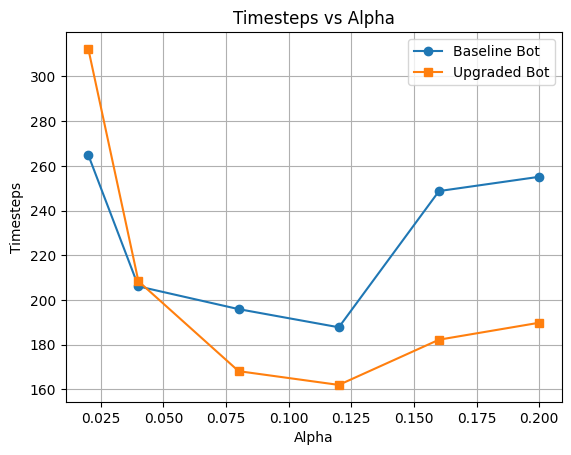

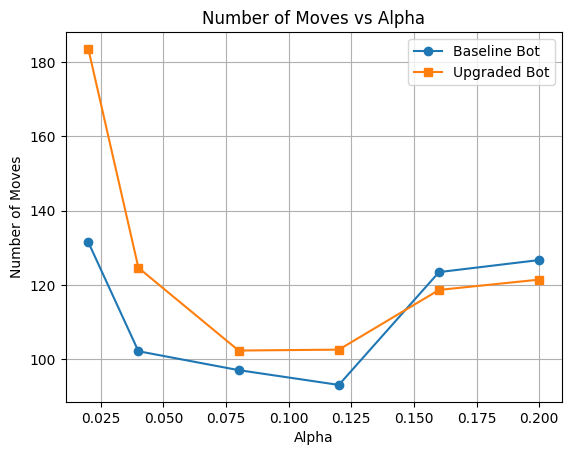

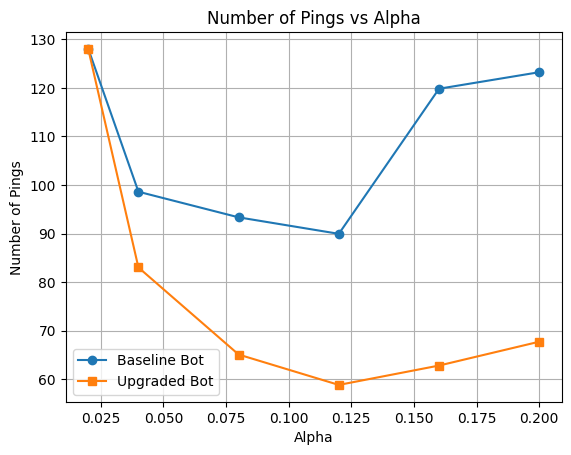

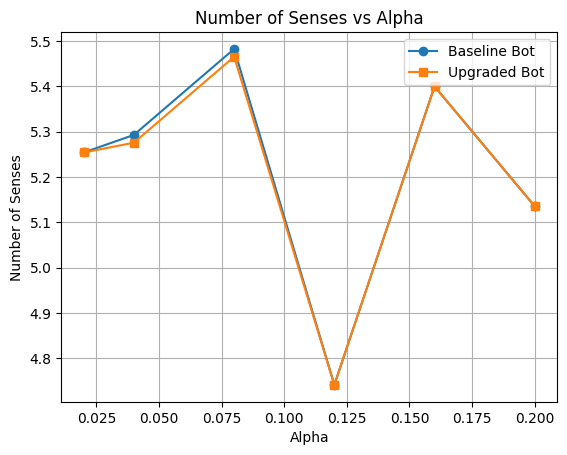

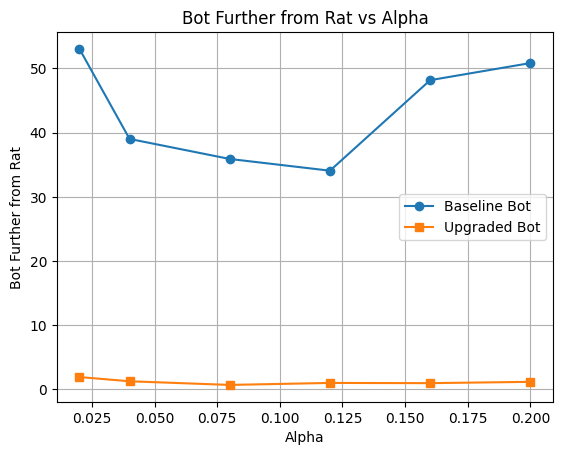

In [ ]:
# Define alpha_list and initialize dataframes
# alpha_list = [0.04, 0.08, 0.12, 0.16, 0.2]
# columns = ['timesteps', 'num_moves', 'num_pings', 'num_senses', 'count_further']

# Initialize the dataframes with zeros (example data)
# success_df_1 = pd.DataFrame(0, index=alpha_list, columns=columns)
# success_df_2 = pd.DataFrame(0, index=alpha_list, columns=columns)

# Generate the plots
for col in columns:
    plt.figure()
    plt.plot(alpha_list, success_df_1[col], label='Baseline Bot', marker='o')
    plt.plot(alpha_list, success_df_2[col], label='Upgraded Bot', marker='s')
    plt.xlabel('Alpha')
    plt.ylabel(col)
    plt.title(f'{col} vs Alpha')
    plt.legend()
    plt.grid(True)
    plt.show()


# Moving Rat Data Analysis

In [ ]:
alpha_list = [0.02, 0.04, 0.08, 0.12, 0.16, 0.2]
columns=['Timesteps', 'Number of Moves', 'Number of Pings', 'Number of Senses', 'Bot Further from Rat']
success_df_1 = pd.DataFrame(0, index=alpha_list, columns=columns)
success_df_2 = pd.DataFrame(0, index=alpha_list, columns=columns)
success_df_3 = pd.DataFrame(0, index=alpha_list, columns=columns)
# success_rates_bot4 = {}
numRounds = 20
# only_bot_4 = []
for alpha in alpha_list:
  t1_list = []
  t2_list = []
  t3_list = []

  num_moves1_list = []
  num_moves2_list = []
  num_moves3_list = []

  num_pings1_list = []
  num_pings2_list = []
  num_pings3_list = []

  num_senses1_list = []
  num_senses2_list = []
  num_senses3_list = []

  count_further1_list = []
  count_further2_list = []
  count_further3_list = []

  for i in range(numRounds):
    gridX = createBoard(30)
    botLoc, ratLoc = location_init(gridX)

    try:
      num_moves1, num_pings1, num_senses1, t1, count_further1 = baseline_bot_loop_movingRat(gridX, botLoc, ratLoc, alpha)
      num_moves2, num_pings2, num_senses2, t2, count_further2 = upgraded_bot_movingRat(gridX, botLoc, ratLoc, alpha)
      num_moves3, num_pings3, num_senses3, t3, count_further3 = third_bot(gridX, botLoc, ratLoc)
    except Exception as error:
      # print(error)
      continue

    t1_list.append(t1)
    t2_list.append(t2)
    t3_list.append(t3)

    num_moves1_list.append(num_moves1)
    num_moves2_list.append(num_moves2)
    num_moves3_list.append(num_moves3)

    num_pings1_list.append(num_pings1)
    num_pings2_list.append(num_pings2)
    num_pings3_list.append(num_pings3)

    num_senses1_list.append(num_senses1)
    num_senses2_list.append(num_senses2)
    num_senses3_list.append(num_senses3)

    count_further1_list.append(count_further1)
    count_further2_list.append(count_further2)
    count_further3_list.append(count_further3)

    # print(f"Run {i} of {numRounds}, alpha = {alpha}")

  success_df_1.loc[alpha] = [np.average(t1_list),
                             np.average(num_moves1_list),
                             np.average(num_pings1_list),
                             np.average(num_senses1_list),
                             np.average(count_further1_list)]

  success_df_2.loc[alpha] = [np.average(t2_list),
                             np.average(num_moves2_list),
                             np.average(num_pings2_list),
                             np.average(num_senses2_list),
                             np.average(count_further2_list)]

  success_df_3.loc[alpha] = [np.average(t3_list),
                             np.average(num_moves3_list),
                             np.average(num_pings3_list),
                             np.average(num_senses3_list),
                             np.average(count_further3_list)]
  print(success_df_1.loc[alpha])
  print(success_df_2.loc[alpha])
  print(success_df_3.loc[alpha])

<ipython-input-28-342b91992517>:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1521.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  success_df_1.loc[alpha] = [np.average(t1_list),
<ipython-input-28-342b91992517>:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '759.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  success_df_1.loc[alpha] = [np.average(t1_list),
<ipython-input-28-342b91992517>:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '755.85' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  success_df_1.loc[alpha] = [np.average(t1_list),
<ipython-input-28-342b91992517>:64: FutureWarning: Setting an item of i

Timesteps               1521.40
Number of Moves          759.80
Number of Pings          755.85
Number of Senses           5.75
Bot Further from Rat     375.45
Name: 0.02, dtype: float64
Timesteps               1325.80
Number of Moves          967.95
Number of Pings          357.05
Number of Senses           5.75
Bot Further from Rat      22.00
Name: 0.02, dtype: float64
Timesteps               9431.2
Number of Moves            0.0
Number of Pings         9431.2
Number of Senses           0.0
Bot Further from Rat    4724.1
Name: 0.02, dtype: float64


<ipython-input-28-342b91992517>:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.555555555555557' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  success_df_2.loc[alpha] = [np.average(t2_list),


Timesteps               1627.611111
Number of Moves          812.888889
Number of Pings          809.666667
Number of Senses           5.055556
Bot Further from Rat     392.833333
Name: 0.04, dtype: float64
Timesteps               1034.444444
Number of Moves          793.333333
Number of Pings          240.333333
Number of Senses           4.944444
Bot Further from Rat      19.555556
Name: 0.04, dtype: float64
Timesteps               9566.333333
Number of Moves            0.000000
Number of Pings         9566.333333
Number of Senses           0.000000
Bot Further from Rat    4795.000000
Name: 0.04, dtype: float64
Timesteps               1937.764706
Number of Moves          967.941176
Number of Pings          964.647059
Number of Senses           5.176471
Bot Further from Rat     475.882353
Name: 0.08, dtype: float64
Timesteps               2928.411765
Number of Moves         2512.235294
Number of Pings          415.294118
Number of Senses           5.176471
Bot Further from Rat      97

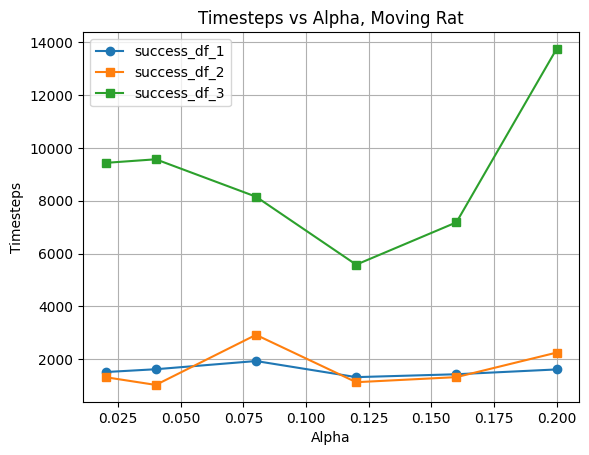

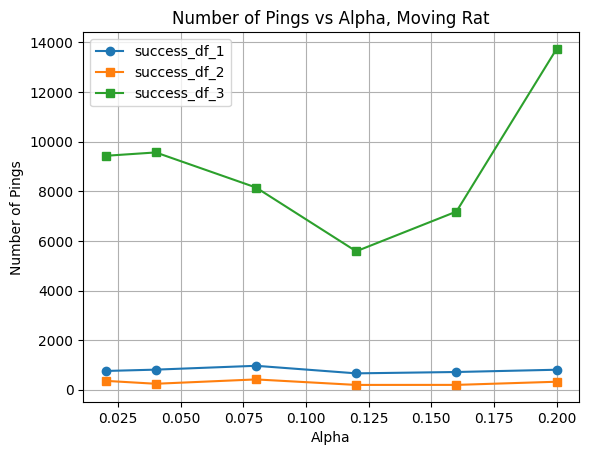

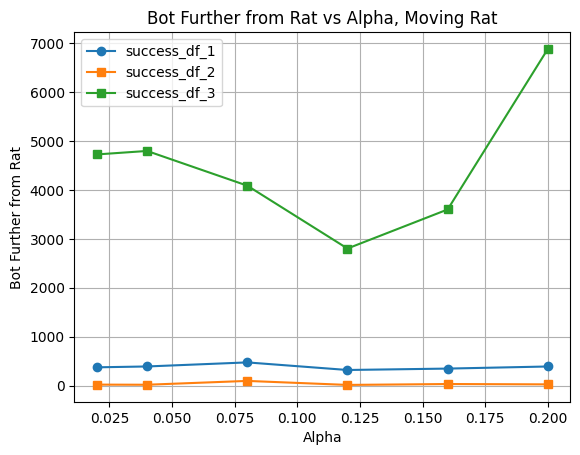

In [ ]:
cols_1 = ['Timesteps', 'Number of Pings', 'Bot Further from Rat']

for col in cols_1:
    plt.figure()
    plt.plot(alpha_list, success_df_1[col], label='success_df_1', marker='o')
    plt.plot(alpha_list, success_df_2[col], label='success_df_2', marker='s')
    plt.plot(alpha_list, success_df_3[col], label='success_df_3', marker='s')
    plt.xlabel('Alpha')
    plt.ylabel(col)
    plt.title(f'{col} vs Alpha, Moving Rat')
    plt.legend()
    plt.grid(True)
    plt.show()

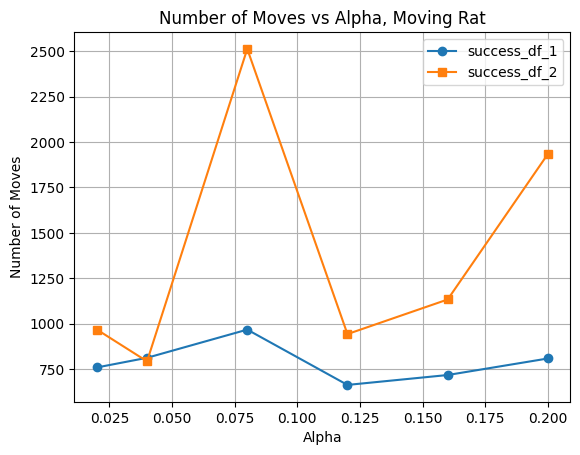

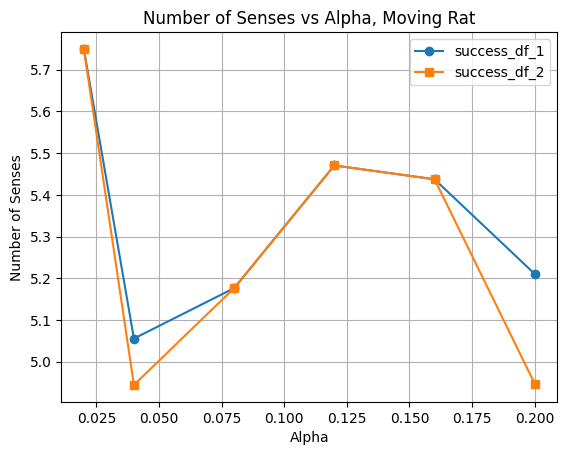

In [ ]:
cols_2 = ['Number of Moves', 'Number of Senses']
for col in cols_2:
    plt.figure()
    plt.plot(alpha_list, success_df_1[col], label='success_df_1', marker='o')
    plt.plot(alpha_list, success_df_2[col], label='success_df_2', marker='s')
    plt.xlabel('Alpha')
    plt.ylabel(col)
    plt.title(f'{col} vs Alpha, Moving Rat')
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. Knowledge Base Update Logic
The probability that the rat is in a cell $ij$, given that it heard a ping at $t^{th}$ attempt, can be expressed using Bayesian inference:

$$P_t(\text{rat}_{ij}|\text{ping})=\frac{P_{t-1}(\text{rat}_{ij})P(\text{ping|}\text{rat}_{ij})}{P_{t-1}(\text{ping})}$$
\
Where $P_{t-1}(\text{rat}_{ij})$ is the prior probability. We then have that

$$P_t(\text{rat}_{ij}|\text{no ping})=\frac{P_{t-1}(\text{rat}_{ij})\left(1-P(\text{ping|}\text{rat}_{ij})\right)}{P_{t-1}(\text{ping})}$$
\
We already have $P(\text{ping|}\text{rat}_{ij})$ because this is given to us in the form of $e^{-\alpha(d-1)}$.
\
We also initialize
$$P_0(\text{rat}_{ij})=\frac{1}{N_\text{open}}$$
as our first prior probability.
\
We know that the probability of a ping given the rat's position because it is a function of the rat's manhattan distance from the bot, $e^{-\alpha (d - 1)}$, and that the probability of the rat at time 0 is 1 divided by the number of open cells in the ship (since our belief in any given step having the rat is equal when we have no information). This begs the question, what about ${P_{t-1}(ping_{ij})}$? We must consider in this case that we are using these probabilities solely for comparing to each other and walking towards the highest probability cell. In this case, for any two cells, their probabilities of having the rat as far as we know both have the same denominator of ${P_{t-1}(ping_{ij})}$. Thus, this cancels out and even though we don't know exactly its value, we are fine without it. We propagate these probabilities throughout the ship cells for all cells, with walls initialized to have probability of 0 at the beginning. As a result, our confidence in cells around us having the cell and not further away cells increases when we get a ping response, and it falls for closer cells while rising for further away cells when we do not get a ping response.

# 2. Upgraded Bot Logic
Our algorithm for the upgraded bot is as follows:
1. Determine whether the rat and the bot are in the same cell. If so, terminate algorithm
2. Ping $x$ times, each time updating the probabilities of each cell based on the knowledge base update procedure described earlier.
\
We determine $x$ with the expression $10e^{-13p_{max}}$, where $p_{max}=$ the maximum probability in the grid before pinging. This allows us to use more pings when we have less confidence in a certain cell containing the rat, and less pings when we are very confident in a certain cell.
3. Calculate utilities using the function $U(\text{cell})=\theta_0p(\text{cell})+\theta_1d$, where:
\
$\theta_0=$ weight for $p$ of a given cell, which we have set to $1$.
\
$\theta_1=$ weight for $d$ (manhattan distance) between current location and given cell, which after trial and error we have set to $10^{-8}$. This number seems small but had a measurable difference in the bot's performance.
4. Calculate the shortest path between the current cell and the highest-utility cell. If the length of this path $>25$, traverse half of the path to avoid moving too far in the wrong direction, then return to (1). Otherwise, travel the full path, then return to (1).

# 3. Bot Evaluations
(You can see our plots above in the output for the Data Analysis cells). We plotted 6 points averaging the timesteps, number of pings, number of senses, number of walks, and number of steps made away from the rat over 60 trials per bot. Overall, our data itself points towards the following:

* As for timesteps our upgraded bot overall matches the baseline bot in timesteps for lower versions of alpha (at 0.02 and 0.04) but slightly doing worse at 0.08. However, from 0.12 to 0.2 we found that our bot began performing considerably better than the baseline bot, meaning that as we actually performed better with less overall information (less ping responses). Our strategy seems to fare better in total average timesteps over all the tested alpha as well, since the differences in timesteps when the upgraded bot performed better outweigh the difference in timesteps when it performed worse. We did not include these in the plot but for larger alphas than 0.2 we found it (often) took seemingly un-uniformly distributed timesteps over many trials, and it was hard to tell the difference between the two bots over multiple runs of the 60 trials. So, in the interest of time and meaningful data, we stuck to keeping 0.2 as our max alpha.
* Our upgraded bot moves more than the baseline bot for all alpha values, with this gap thinning a little at higher alpha values. This is likely due to the upgraded bot often overwalking because we don't collect as much information as the baseline bot does. Because the baseline bot pings at every turn, every step is more informed than the last.
* The upgraded bot overall pings significantly less than the baseline bot, largely due to two factors. Firstly, because we ping several times and then move, we implemented the number of times we ping on a given grid state and knowledge base state as a function of the maximum probability of our knowledgebase (i.e.  our maximum confidence at a cell). The general idea is that because we want to ping more when we have less information and are therefore less confident and we want to ping less when we only consider the rat to be between a few cells and our confidence is fairly high, we can minimize the number of pings needed using our exponential decay function. This is the primary way we minimize timesteps, as the baseline bot's strategy of pinging every time a new tile is walked on can cause redundancy and an excess of information where fewer pings could suffice.
* The upgraded bot's number of senses overall don't differ dramatically from the baseline bot, as the steps taken to find the bot's position in the grid are more or less the same.
* Interestingly, our bot takes steps away from the rat very few times compared to the baseline bot at all values of alpha. This is because we incorporate a failsafe for when we travel long distances to avoid overshooting--we stop halfway through our trip and ping a few times again to decide if we want to continue on our way, or change our direction to be closer to the rat given our new set of measurements. More often than not, we have found that the new measurements take us away from our initial destination and closer to the rat's general area as a result of the new measurements we get. This means that our upgraded bot design is significantly better at actually getting closer to the rat with each step.


# 4. Moving Rat Situation Analysis
1. Our calculation of the rate knowledge base updates, given a moving rat, is now based on the hidden Markov model for prediction. For a given cell $x, t+k+1$ steps in the future, we have $\text{Predict}(x)_t^{k+1}=\sum_{x'}\text{Predict}(x')_t^kP(x|x')$, where:
\
${x'}$ denotes the neighbors of $x$: since the rat can only move through one cell at a time, we can model each cell's probability in terms of only its neighbors;
\
$\text{Predict}(x)_t^{0}=\text{Belief}(x)_t=P_{t}(\text{rat}_{x})$, which is the probability from earlier that the rat is currently in cell $x$;
\
$P(x|x')=$ the probability that, assuming the rat is in neighbor $x'$, the rat would end up in $x$.
\
The baseline bot will only be predicting one timestep into the future, since it operates one step at a time. However, the upgraded bot will seek to predict many timesteps into the future, which can become computationally expensive as we recursively consider many neighbors. Therefore, we will use a simulation method for the upgrade:
* After the bot picks the highest-utility cell, it will assume that the rat is in fact in that cell. Then, it will simulate the rat moving for as long as it would take for the bot to reach that cell, simulating this situation 25 times. Finally, it would pick whichever cell the rat went to the most often across all simulations and choose that as its new destination, and the algorithm proceeds as normal.
2. According to our results, the upgraded bot design performed significantly better than baseline for nearly all measures, across all values of $\alpha$. However, as $\alpha$ increased, the upgraded bot tended to move more than the baseline. This was an expected result, as the upgraded bot is designed to move more than baseline for all $\alpha$. We believe we can explain the upgraded bot's performance in the moving rat scenario. We can believe that if the rat is in a cell $k$ steps away, then by the time the bot reaches that cell, the rat will be $k$ steps away from it. Therefore, it's generally in the bot's best interest to only go half the distance $(k/2)$ to attempt to meet the rat in the middle, which is exactly what the upgraded bot does anyways.
3. We attempted a radical proposal to improve our bot design: a third bot that simply sits and waits for the rat to reach it. However, this bot performed significantly worse than both baseline and upgraded. Despite this, the stationary bot serves as a useful reference point for the other two bot designs. In addition to this proposal, we attempted different knowledge base update policies such as higher weightage for high-confidence regions of the grid, as well as behavioral policies such as remaining stationary once the bot was in high-confidence regions. However, none of these proposals outperformed our existing upgraded bot design.